<a href="https://colab.research.google.com/github/ntsurayya/statistics_ab-testing_landing-page/blob/main/statistics_ab-testing_landing-page.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><span style='background :#F5EEF3' > A/B Testing on Landing Page

**Contents:**
1. Data Cleaning
2. Exploratory Data Analysis
3. A/B Testing

# Import Library

In [ ]:
#NOTE: Restart runtime after running this code
!pip install --upgrade matplotlib==3.4

In [ ]:
import matplotlib 
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.4.0


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
import math
import statsmodels.stats.api as sm
import scipy.stats as stats
import matplotlib
from math import ceil

# Read File

In [ ]:
df = pd.read_csv('ab_data.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


# About Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
df.describe(include='all')

,user_id,timestamp,group,landing_page,converted
count,294478.000000,294478,294478,294478,294478.000000
unique,NaN,294478,2,2,NaN
top,NaN,2017-01-21 22:11:48.556739,treatment,old_page,NaN
freq,NaN,1,147276,147239,NaN
mean,787974.124733,NaN,NaN,NaN,0.119659
std,91210.823776,NaN,NaN,NaN,0.324563
min,630000.000000,NaN,NaN,NaN,0.000000
25%,709032.250000,NaN,NaN,NaN,0.000000
50%,787933.500000,NaN,NaN,NaN,0.000000
75%,866911.750000,NaN,NaN,NaN,0.000000


# Data Cleaning

### Missing Value

In [ ]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No missing value.

### Duplicate Data

In [ ]:
total_duplicate = df.duplicated().sum()
duplicate_user = df['user_id'].value_counts()
multi_users = duplicate_user[duplicate_user > 1].count()

print('Total of duplicate data: {}'.format(total_duplicate))
print('Total of duplicate data based user_id:', multi_users)

Total of duplicate data: 0
Total of duplicate data based user_id: 3894


Handling Duplicate Data by Drop it

In [ ]:
drop_duplicate = duplicate_user[duplicate_user > 1].index
df = df[~df['user_id'].isin(drop_duplicate)]

Re-check Duplicate Data

In [ ]:
duplicate_user = df['user_id'].value_counts()
multi_users = duplicate_user[duplicate_user > 1].count()
print('Total of duplicate data based user_id:', multi_users)

Total of duplicate data based user_id: 0


### Add 'date' from 'timestamp'

Add New Column 'date' 

In [ ]:
from datetime import datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
date = df['timestamp'].dt.date
df.insert(2, 'date', date)
df.head(3)

,user_id,timestamp,date,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,2017-01-21,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,2017-01-12,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,2017-01-11,treatment,new_page,0


Add New Column 'day' 

In [ ]:
df['date'] = pd.to_datetime(df['date'])
day = df['date'].dt.strftime('%a')
df.insert(3, 'day', day)
df.head(3)

,user_id,timestamp,date,day,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,2017-01-21,Sat,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,2017-01-12,Thu,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,2017-01-11,Wed,treatment,new_page,0


## Summary Data Cleaning

In [ ]:
types = df.dtypes
distinct = df.nunique()
count_na = df.isna().sum()
percent_na = round((df.isna().sum()/len(df))*100, 3)

df_check = pd.concat([types, distinct, count_na, percent_na], axis = 1)

df_check.reset_index(level = 0, inplace = True) 
df_check.rename(columns = {'index' : 'column', 0: 'dtypes', 1: 'distinct', 2: 'count_na', 3: 'percent_na'}, inplace = True)
df_check

,column,dtypes,distinct,count_na,percent_na
0,user_id,int64,286690,0,0.0
1,timestamp,datetime64[ns],286690,0,0.0
2,date,datetime64[ns],23,0,0.0
3,day,object,7,0,0.0
4,group,object,2,0,0.0
5,landing_page,object,2,0,0.0
6,converted,int64,2,0,0.0


# Exploratory Data Analysis

In [ ]:
weekly_converted = df.groupby(['day','converted']).agg(count = ('converted', 'count')).reset_index()

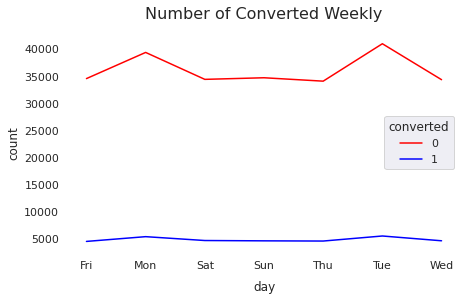

In [ ]:
fig, az = plt.subplots(figsize=(7, 4))
az = sns.lineplot(data=weekly_converted, x='day', y='count', hue='converted', palette=['red', 'blue'])
az.set_facecolor('white')
plt.title('Number of Converted Weekly', pad=15, size=16)
plt.xlabel('day', labelpad=10)
plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.show()

* Based on weekly line plots, this indicates that users are likely to end sessions without conversions [0].
* However, further analysis is needed to conclude which landing page is better.

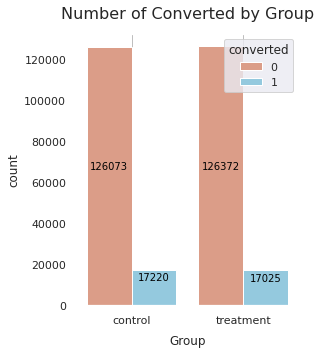

In [ ]:
fig, ay = plt.subplots(figsize=(4, 5))
ay = sns.countplot(data=df, x='group', hue='converted', palette=['darksalmon','skyblue'])
ay.bar_label(ay.containers[0], size=10, color= 'black', label_type='center', padding=10)
ay.bar_label(ay.containers[1], size=10, color= 'black', label_type='center', padding=10)
ay.set_facecolor('white')
plt.title('Number of Converted by Group', pad=15, size=16)
plt.xlabel('Group', labelpad=10)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5)
plt.show()

* Based on count plot, there is no significant difference in the number of the two groups whether to make conversion [1] or not [0] about landing page. 
* However, it can be seen that ending a session without conversion [0] is more than making conversion.

# Sampling

### Sample Size

In [ ]:
# Calculating effect size based on our expected rates
effect_size = sm.proportion_effectsize(0.13, 0.15)

# Calculating sample size needed
required_n = ceil(sm.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1))

print('Sample size required for A/B Testing:', required_n, 'for a group,', required_n*2, 'for two groups')

Sample size required for A/B Testing: 4720 for a group, 9440 for two groups


Dataframe for A/B Testing (n=9440)

In [ ]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,date,day,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,2017-01-21,Sat,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,2017-01-18,Wed,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,2017-01-06,Fri,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,2017-01-05,Thu,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,2017-01-04,Wed,control,old_page,0
...,...,...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,2017-01-14,Sat,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,2017-01-05,Thu,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,2017-01-20,Fri,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,2017-01-03,Tue,treatment,new_page,0


### Exploratory Data Analysis (A/B Testing)

In [ ]:
pd.crosstab(ab_test['group'], ab_test['converted'])

converted,0,1
group,,
control,4138,582
treatment,4127,593


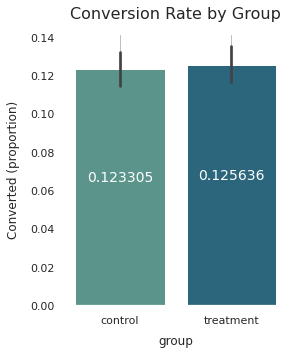

In [ ]:
fig, ax = plt.subplots(figsize=(4, 5))
ax = sns.barplot(ab_test['group'], ab_test['converted'], palette='crest')
ax.bar_label(ax.containers[0], size=14, color= 'white', label_type='center', padding=10)
ax.set_facecolor('white')
plt.title('Conversion Rate by Group', pad=15, size=16)
plt.xlabel('group', labelpad=10)
plt.ylabel('Converted (proportion)', labelpad=10)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5)
plt.show()

* Based on the conversion rate between the two groups, the percentage of users who ended the session with a conversion is almost the same which is around 12 - 13% while there are 87 - 88% who ended the session with no conversion.
* So, it is necessary to check if the difference is statistically significant.

# A/B Testing

### Hypothesis

**A Two-Tailed Test**
* H0: p1 - p2 = 0 or p1 = p2
* H1: p1 - p2 != 0 pr p1 != p2

**Hypothesis based on Data**
* H0: control = treatment  (Landing Page Changes Have a Significant Effect)
* H1: control != treatment (Landing Page Changes Have No Significant Effect)

**p1 = control; p2 = treatment**

### Statistical Test (Z-test)

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
p1 = ab_test[ab_test['group'] == 'control']['converted']
p2 = ab_test[ab_test['group'] == 'treatment']['converted']

In [ ]:
n_p1 = p1.count()
n_p2 = p2.count()
success = [p1.sum(), p2.sum()]
n_obs = [n_p1, n_p2]

z_test, pvalue = proportions_ztest(success, nobs=n_obs)

# Confidence interval
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(success, nobs=n_obs, alpha=0.05)

In [ ]:
print('z-test                     : {:.2f}'.format(z_test))
print('p-value                    : {:6.3f}'.format(pvalue))
print('CI 95% for control group   : [{:.3f},{:.3f}]'.format(lower_control, upper_control))
print('CI 95% for treatment group : [{:.3f},{:.3f}]'.format(lower_treatment, upper_treatment))

z-test                     : -0.34
p-value                    :  0.732
CI 95% for control group   : [0.114,0.133]
CI 95% for treatment group : [0.116,0.135]


### Critical Value

Table Value for alpha 5%

In [ ]:
alpha = 0.05
z_alpha_pos = round(stats.norm.ppf(1-alpha/2), 3)
z_alpha_neg = round(stats.norm.ppf(alpha/2), 3)
z_alpha_pos

-2.326

In [ ]:
decision1 = 'Reject H0' if pvalue < alpha else 'Fail to Reject H0' 
decision2 = 'Reject H0' if z_test < z_alpha_neg else 'Fail to Reject H0' 
summary1 = { 'alpha'    : alpha,
             'p-value'  : round(pvalue,3),
             'decision' : decision1}
summary2 = { 'z_alpha_per_2' : z_alpha_neg,
             'z_test'       : round(z_test,3),
             'decision'     : decision2, 
             'CI lower (Control)' : round(lower_control,3),
             'CI upper (Control)' : round(upper_control,3),
             'CI lower (Treatment)' : round(lower_treatment,3),
             'CI upper (Treatment)' : round(upper_treatment,3) }

In [ ]:
display(pd.DataFrame([summary1]))
display(pd.DataFrame([summary2]))

,alpha,p-value,decision
0,0.05,0.732,Fail to Reject H0


,z_alpha_per_2,z_test,decision,CI lower (Control),CI upper (Control),CI lower (Treatment),CI upper (Treatment)
0,-1.96,-0.343,Fail to Reject H0,0.114,0.133,0.116,0.135


* Reject H0: p-value < alpha
* Reject H0: z-test > z(alpha/2)

**CONCLUSION:**
* It can be concluded that decisions related to landing page conversion: fail to reject H0 (or accept H1). 
* It means that landing page changes (old page and new page) have no significant effect.
* The new page does not have a significant effect compared to the old page.
* Recommendation for company: 
1. Keep the old page, or 
2. Update the new version of the existing new page.


